In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.distributions import Uniform

In [2]:
# spline layer definition

class QuadraticSpline(nn.Module):

  def __init__(self, num_knots=10):

    super().__init__()
    self.num_knots = num_knots
    self.knots = torch.linspace(-1,1,num_knots)
    self.values = nn.Parameter(torch.randn(num_knots)) #initializing random values to the knots, since nn.Parameters is incorporated the splines become learnable activation functions

  def compute_coefficients(self):

    x = self.knots
    y = self.values
    n = self.num_knots - 1  # number of intervals

    x = torch.clamp(x, -1 + 1e-6, 1 - 1e-6)

    # initializing coefficient arrays
    A = torch.zeros((3 * n, 3 * n), dtype=y.dtype, device=y.device)
    B = torch.zeros((3 * n,), dtype=y.dtype, device=y.device)

    row = 0

    #equating the boundary conditions for both ends of each interval
    for i in range(n):

      xi, xi1 = x[i], x[i+1]

      A[row, 3 * i + 0] = xi**2 #corresponds to ai
      A[row, 3 * i + 1] = xi    #corresponds to bi
      A[row, 3 * i + 2] = 1     #corresponds to ci
      B[row] = y[i]
      row += 1

      A[row, 3 * i + 0] = xi1**2
      A[row, 3 * i + 1] = xi1
      A[row, 3 * i + 2] = 1
      B[row] = y[i+1]
      row += 1

    #smoothness: fᵢ′(xᵢ₊₁) = fᵢ₊₁′(xᵢ₊₁) -  at the knot where the two polynomials meet, their derivatives must be the same
    #f' = 2*a*x + b
    #fᵢ′(xᵢ₊₁) = fᵢ₊₁′(xᵢ₊₁) ⇒ 2aᵢ·xᵢ₊₁ + bᵢ = 2aᵢ₊₁·xᵢ₊₁ + bᵢ₊₁
    #rewriting it as: 2aᵢ·xᵢ₊₁ + bᵢ − 2aᵢ₊₁·xᵢ₊₁ − bᵢ₊₁ = 0
    for i in range(n - 1):

      xi1 = x[i + 1]

      A[row, 3 * i + 0] = 2 * xi1
      A[row, 3 * i + 1] = 1
      A[row, 3 * (i + 1) + 0] = -2 * xi1
      A[row, 3 * (i + 1) + 1] = -1
      B[row] = 0
      row += 1

    # Add one extra constraint: second derivative at the first point = 0 ⇒ a₀ = 0
    A[row, 0] = 1.0
    B[row] = 0.0
    row += 1


    #solving the system of equationg
    coeffs = torch.linalg.solve(A, B)
    return coeffs.view(n, 3)  #returns a tensor of n rows and 3 columns (containing the coefficients for n intervals)

  def forward(self, x):

    x = torch.clamp(x, -1 + 1e-6, 1 - 1e-6)
    coeffs = self.compute_coefficients()

    # Find interval for each x
    index = torch.bucketize(x, self.knots, right=True)  #returns an index such that x lies between index and index+1
    index = torch.clamp(index, 1, self.num_knots - 1) - 1

    a = coeffs[index, 0]
    b = coeffs[index, 1]
    c = coeffs[index, 2]

    return a * x**2 + b * x + c

In [3]:
#KAN network

class KANWaveFunction(nn.Module):

  def __init__(self, N, num_knots = 10):

    super().__init__()
    self.N = N
    self.alpha = nn.Parameter(torch.tensor(0.5))

    #creating a grid of N*(2*N+1) of phi functions REFER TO THE DIAGRAM IN THE PAPER for better understanding
    self.phi = nn.ModuleList([
        nn.ModuleList([QuadraticSpline(num_knots) for _ in range(N)])
        for _ in range(2*N+1)
    ])

    self.rho = nn.ModuleList([
        QuadraticSpline(num_knots) for _ in range(2*N+1)
    ])

    self.nu = nn.ModuleList([
        QuadraticSpline(num_knots) for _ in range(N*(N-1)//2)
    ])
    #this is for kappa2

  def kappa1(self,x):

    #x has a shape of [batch_size,N] where each input is a N dimensional vector
    out=[]
    for q in range(2*self.N+1):
      inner = 0.0

      for p in range(self.N):
        inner += self.phi[q][p](torch.tanh(x[:,p]))
        #selecting and doing for pth coordinate(xp) iteratively (can do for only one coordinate at a time since it is a univariate function)

      out.append(self.rho[q](torch.tanh(inner)/self.N))

    return torch.stack(out,dim=1).sum(dim=1)
    #by giving dim=1 inside stack, im stacking ACROSS columns
    #calculating sum along dim1 (sum of rho[q])

  def kappa2(self,x,g=0.0,m=1.0):

    out = 0.0
    k=0

    for i in range(self.N):
      for j in range(i+1,self.N):
        delta = x[:,i] - x[:,j]
        mg = m*g
        c = mg * torch.abs(delta) / (1 + (mg * delta)**4)
        z = torch.tanh(c*delta)
        out+=self.nu[k](z)
        k+=1

    return out

  def forward(self,x,g=0.0,m=1.0):
    r2 = torch.sum(x**2,dim=1)  #across columns
    return torch.exp(-self.alpha*r2) * torch.exp(-self.kappa1(x)) * torch.exp(-self.kappa2(x, g, m=1.0))  #output shape is just [batch_size]

  def log_psi(self,x,g=0.0,m=1.0):
    r2 = torch.sum(x**2,dim=1)
    return -self.alpha*r2 - self.kappa1(x) - self.kappa2(x, g, m=1.0)

In [4]:
def double_spline_knots(model):
  def double_knots(spline):
    old_knots = spline.knots
    new_knots = torch.linspace(-1, 1, len(old_knots) * 2 - 1).to(old_knots.device)
    spline.knots = new_knots
    spline.num_knots = len(new_knots)
    spline.values = nn.Parameter(F.interpolate(spline.values[None, None, :], size=len(new_knots), mode='linear')[0, 0])

  for netlist in [model.phi, model.rho, getattr(model, "nu", [])]:
    for item in netlist:
      if isinstance(item, nn.ModuleList):
        for spline in item:
          double_knots(spline)
      elif isinstance(item, QuadraticSpline):
        double_knots(item)

In [5]:
#this class lets you generate samples from the model’s own probability distribution |ψ(x)|² - used to estimate expected energy of the wavefunction
#we dont use torch.randn since that gives samples from a random distribtuion and not from the model's distributions

# Metropolis-Hastings Sampler

class MetropolisSampler():

  def __init__(self,model,step_size=0.1):
    self.model=model
    self.step_size = step_size

  def sample(self, x_initial, num_samples,g=0.0):
    x = x_initial.clone().detach().requires_grad_(False)
    samples=[]

    with torch.no_grad():
      for _ in range(num_samples):
        x_new = x + torch.randn_like(x) * self.step_size
        #adding random noise to the current sample, the step size is to ensure it moves just the right amount from the current sample
        prob_old = self.model(x,g=g)**2
        prob_new = self.model(x_new,g=g)**2

        accept = (torch.randn_like(prob_old) < (prob_old/prob_new)).float()   #tensor of 0s and 1s of size batch_size
        x = accept.view(-1, 1)*x_new + (1 - accept).view(-1, 1)*x        #updating the accepted values and the old values remain as x
        samples.append(x.clone().detach())  #samples is a list of 2d tensors of size [batch_size,N] - list length is num_samples

    return torch.stack(samples)

In [6]:
#VMC Module

def local_energy(model, x, m=1.0, w=1.0, g=0.0):

  x.requires_grad_(True)
  log_psi=model.log_psi(x,g=g)  #computing gradient for logpsi instead of psi for simplicity
  #since autograd takes only scalar but logspi is a tensor of size batch_size, we used log_psi.sum()
  #but the shape of grad will be [batch_size,N], so effectively the gradient is calulated seperately - possible due to backtracking of autograd
  grad=torch.autograd.grad(log_psi.sum(),x,create_graph=True)[0]
  #note that torch.autograd returns a tuple with the tensor inside it so we write [0] to just extract the tensor.

  #computing the laplacian (basically the generalisation of double derivative)
  laplacian=0.0
  for i in range(x.shape[1]): #calculating for each dimension and summing it up
    laplacian+=torch.autograd.grad(grad[:,i].sum(),x,create_graph=True)[0][:,i] #the shape of this tensor is [batch_size,N], [:,i] since you only want for the ith dimension

  K = -0.5/m*laplacian
  V = 0.5*m*w**2*torch.sum(x**2,dim=1)  #across columns since the dimensions are present across in the tensor

  #the below term is for the interaction energy between particles
  #the true delta function cannot be calculated and hence we approximate it to gaussian function

  delta_energy = 0.0
  sigma=0.1
  norm = 1.0/(sigma*np.sqrt(2*np.pi))
  for i in range(x.shape[1]):
    for j in range(i+1, x.shape[1]):
      delta_energy+=norm * torch.exp(-0.5 * ((x[:, i] - x[:, j]) / sigma) ** 2)
  V_int = g*delta_energy

  return K+V+V_int

In [7]:
#training loop

lr = 0.001
epochs = 200
batch_size = 32
n_samples = 200
g = 0.05
g_start = 0.05
g_target = 0.5
g_step_size = 50
knot_step_size = 50

model = KANWaveFunction(N=2)
sampler = MetropolisSampler(model)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
x = torch.randn(batch_size, model.N)

energy_history = []

for epoch in range(epochs):
  samples = sampler.sample(x, n_samples, g=g).reshape(-1, model.N)
  x = samples[-1].detach().unsqueeze(0) #since the sampler works in sort of like a chain, this x is used for the next round of sampling
  #unsquezing is to convert the 1d to 2d tensor

  E_loc = local_energy(model, samples,g=g)
  loss = E_loc.mean() #lower the ground state energy, better the model

  #updating coupling constant
  if (epoch + 1) % g_step_size == 0 and g < g_target:
    g = min(g + 0.05, g_target)
    print(f"[epoch {epoch}] Increased g to {g:.2f}")

  #doubling knots
  if (epoch + 1) % knot_step_size == 0:
    double_spline_knots(model)
    print(f"[epoch {epoch}] Doubled knot count")

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  scheduler.step()

  energy_history.append(loss.item())

  if epoch % 50 == 0:
    print(f"Epoch {epoch}, Loss: {loss.item()}")


Epoch 0, Loss: -2571.36572265625
[epoch 49] Increased g to 0.10
[epoch 49] Doubled knot count
Epoch 50, Loss: 59.580039978027344
[epoch 99] Increased g to 0.15
[epoch 99] Doubled knot count
Epoch 100, Loss: 60.939212799072266
[epoch 149] Increased g to 0.20
[epoch 149] Doubled knot count
Epoch 150, Loss: 58.963111877441406
[epoch 199] Increased g to 0.25
[epoch 199] Doubled knot count


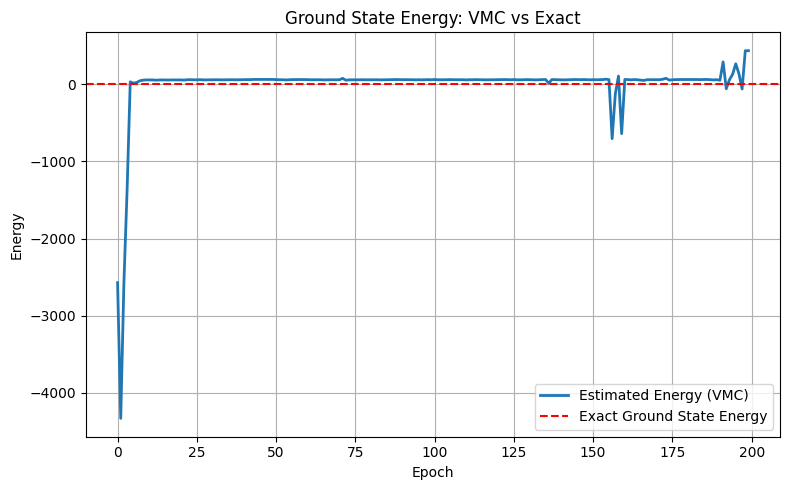

In [8]:
import matplotlib.pyplot as plt

def exact_ground_state_energy(N, g, m=1.0, w=1.0):
    return (N * w) / 2 - (m * g**2 * N * (N**2 - 1)) / 24

# Compute the exact ground state energy
exact_energy = exact_ground_state_energy(N=2, g=0.5)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(energy_history, label="Estimated Energy (VMC)", linewidth=2)
plt.axhline(y=exact_energy, color='red', linestyle='--', label="Exact Ground State Energy")
plt.xlabel("Epoch")
plt.ylabel("Energy")
plt.title("Ground State Energy: VMC vs Exact")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
